In [1]:
import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt
import scripts.mytools as mytools

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

In [3]:
df = pd.read_csv('raw_data/dados_A215_H_2008-06-13_2024-01-01.csv',sep= ';', header = 9)
df['Data Medicao'] = pd.to_datetime(df['Data Medicao'])
df['Hora Medicao'] = pd.to_datetime(df['Hora Medicao'])
df['ano'] = df['Data Medicao'].dt.year
df['mes'] = df['Data Medicao'].dt.month
df['dia'] = df['Data Medicao'].dt.day
# df['hora']= df['Hora Medicao'].str[-4:-2].astype(int)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '.').astype(float)


df['Hora Medicao'] = df['Hora Medicao'].astype(str)
df['hora'] = df['Hora Medicao'].str[-4:-2].astype(int)
df = df.drop(['Hora Medicao'],axis=1)
df['hora'] = pd.to_timedelta(df['hora'], unit='h') - pd.Timedelta(hours=3)
df['Data_Hora'] = df['Data Medicao'] + df['hora']
df.set_index('Data_Hora', inplace=True)
df['Data_Hora'] = df['Data Medicao'] + df['hora']
df = df.drop('Unnamed: 22', axis =1)
df['estacao'] = df.apply(mytools.encontrar_estacao, axis=1)


In [4]:
ml_cropped = mytools.cortar_serie_temporal(df,data_inicio = '2010-01-01', data_fim = '2019-12-31')
extrapolation = mytools.cortar_serie_temporal(df,data_inicio = '2020-01-01', data_fim = '2024-01-01')


In [5]:
'''def plot_missing_values(df):
    """ For each column with missing values plot proportion that is missing."""
    data = [(col, df[col].isnull().sum() / len(df)) 
            for col in df.columns if df[col].isnull().sum() > 0]
    col_names = ['column', 'percent_missing']
    missing_df = pd.DataFrame(data, columns=col_names).sort_values('percent_missing')
    pylab.rcParams['figure.figsize'] = (16, 8)
    missing_df.plot(kind='barh', x='column', y='percent_missing'); 
    plt.title('Percent of missing values in colummns')
    '''

'def plot_missing_values(df):\n    """ For each column with missing values plot proportion that is missing."""\n    data = [(col, df[col].isnull().sum() / len(df)) \n            for col in df.columns if df[col].isnull().sum() > 0]\n    col_names = [\'column\', \'percent_missing\']\n    missing_df = pd.DataFrame(data, columns=col_names).sort_values(\'percent_missing\')\n    pylab.rcParams[\'figure.figsize\'] = (16, 8)\n    missing_df.plot(kind=\'barh\', x=\'column\', y=\'percent_missing\'); \n    plt.title(\'Percent of missing values in colummns\')\n    '

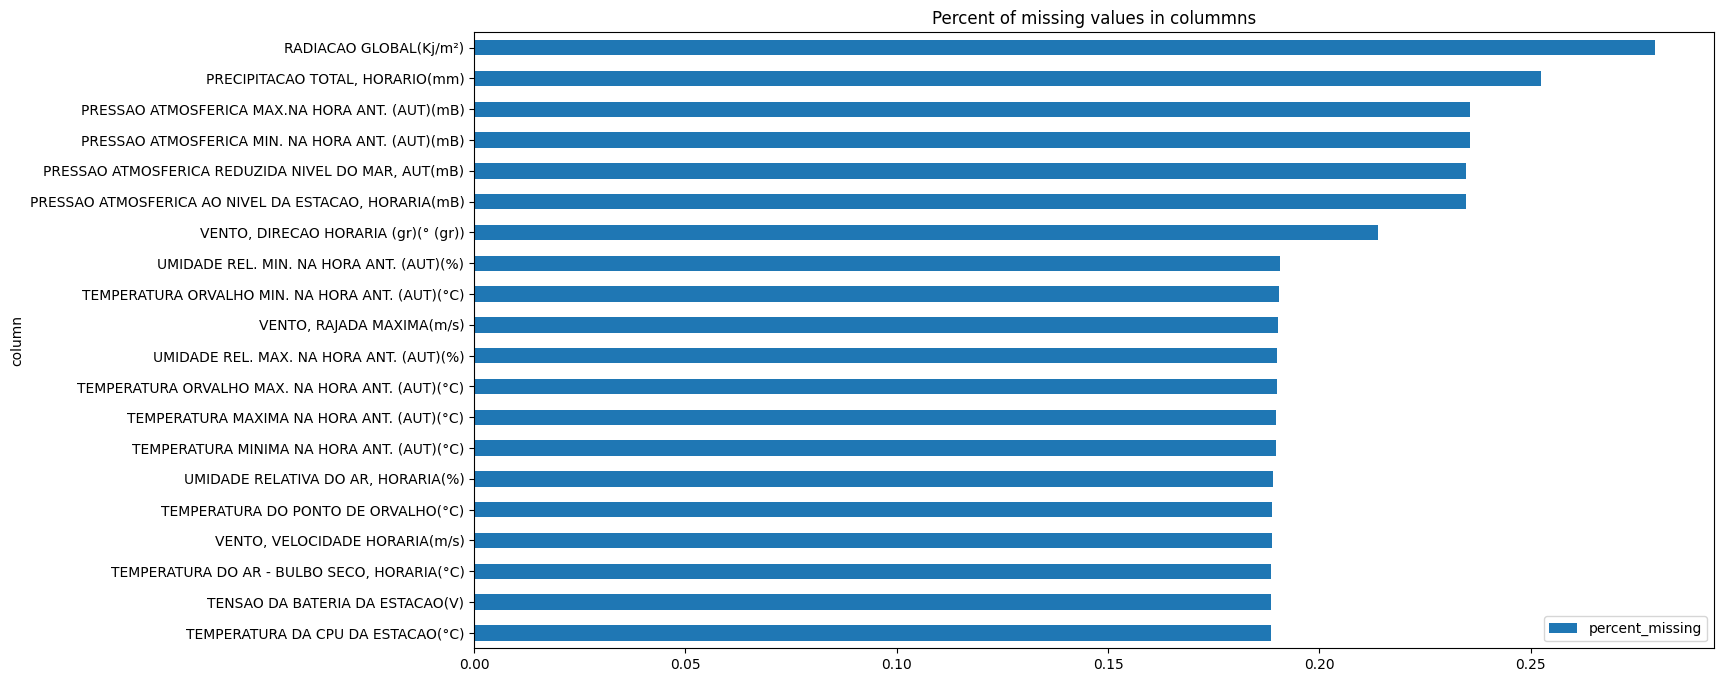

In [6]:
mytools.plot_missing_values(df)

In [37]:
df = ml_cropped.dropna()
ml_cropped.to_csv('processed_data/ml_cropped(2010-2020).csv')

In [8]:
col_numericas = [
    'PRECIPITACAO TOTAL, HORARIO(mm)', 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)',
    'PRESSAO ATMOSFERICA REDUZIDA NIVEL DO MAR, AUT(mB)',
    'PRESSAO ATMOSFERICA MAX.NA HORA ANT. (AUT)(mB)',
    'PRESSAO ATMOSFERICA MIN. NA HORA ANT. (AUT)(mB)',
    'RADIACAO GLOBAL(Kj/m²)', 'TEMPERATURA DA CPU DA ESTACAO(°C)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)',
    'TEMPERATURA DO PONTO DE ORVALHO(°C)',
    'TEMPERATURA MAXIMA NA HORA ANT. (AUT)(°C)',
    'TEMPERATURA MINIMA NA HORA ANT. (AUT)(°C)',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT)(°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT)(°C)',
    'TENSAO DA BATERIA DA ESTACAO(V)',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT)(%)',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT)(%)',
    'UMIDADE RELATIVA DO AR, HORARIA(%)', 'VENTO, RAJADA MAXIMA(m/s)',
    'VENTO, VELOCIDADE HORARIA(m/s)'
]

col_categoricas = ['estacao']

In [9]:
# features = ['TEMPERATURA DO PONTO DE ORVALHO(°C)','VENTO, VELOCIDADE HORARIA(m/s)', 'UMIDADE RELATIVA DO AR, HORARIA(%)', 'TEMPERATURA DO AR - BULBO SECO, HORARIA(°C)']
parametros = (col_numericas + col_categoricas)
variavel = ['RADIACAO GLOBAL(Kj/m²)']
features = df[parametros]
target = df[variavel]
X = features.values
y = target.values

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)
from sklearn.model_selection import TimeSeriesSplit 
tss = TimeSeriesSplit(n_splits = 5,
                      gap = 0)

In [11]:
for train_index, test_index in tss.split(X):
    X_train, X_test = features.iloc[train_index, :], features.iloc[test_index,:]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

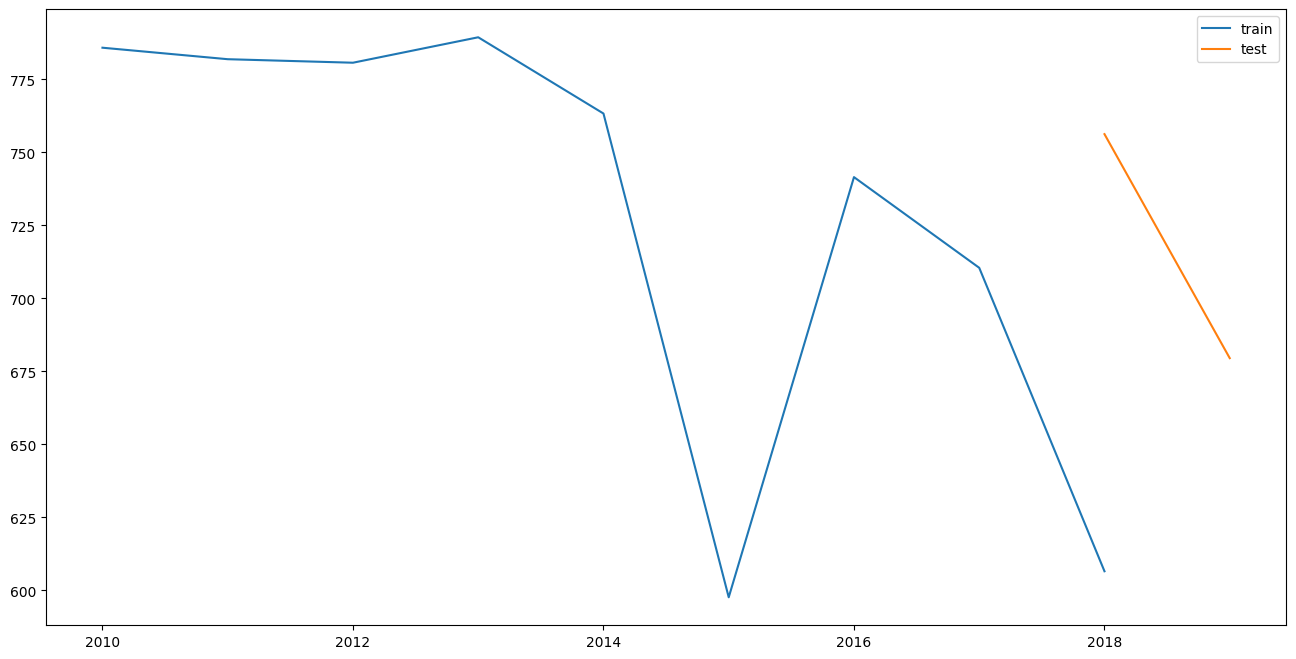

In [12]:
ax = plt.subplot()
ax.plot(y_train.groupby(df['Data_Hora'].dt.year).mean(), label = 'train')
ax.plot(y_test.groupby(df['Data_Hora'].dt.year).mean(), label = 'test')
ax.legend()
plt.show()

In [19]:
all_splits = list(tss.split(features, target))

In [20]:
train_idx, test_idx = all_splits[0]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]

In [26]:
X.shape

(77316, 20)

In [28]:
df.shape

(77316, 27)

In [25]:
for fold, (train_index, test_index) in enumerate(tss.split(X,y)):
  X_train, X_test = features.iloc[train_index, :], features.iloc[test_index,:]
  y_train, y_test = target.iloc[train_index], target.iloc[test_index]
  print("Fold: {}".format(fold))
  print("\tTRAIN indices:", train_index)
  print("\tTEST indices:", test_index)
  # for fold,(train_index,test_index) in enumerate(tss.split(df)):
  
    

Fold: 0
	TRAIN indices: [    0     1     2 ... 12883 12884 12885]
	TEST indices: [12886 12887 12888 ... 25769 25770 25771]
Fold: 1
	TRAIN indices: [    0     1     2 ... 25769 25770 25771]
	TEST indices: [25772 25773 25774 ... 38655 38656 38657]
Fold: 2
	TRAIN indices: [    0     1     2 ... 38655 38656 38657]
	TEST indices: [38658 38659 38660 ... 51541 51542 51543]
Fold: 3
	TRAIN indices: [    0     1     2 ... 51541 51542 51543]
	TEST indices: [51544 51545 51546 ... 64427 64428 64429]
Fold: 4
	TRAIN indices: [    0     1     2 ... 64427 64428 64429]
	TEST indices: [64430 64431 64432 ... 77313 77314 77315]


In [15]:
#Criando Time-Lagging Features, can add freq = 1D, 1M, 1Y in shift function
#qual variavel devo adicionar o time lag?
'''
df.sort_values('date', inplace=True)
df['silver_lag_1'] = df['silver'].shift(1)
df['silver_lag_5'] = df['silver'].shift(5)
'''

"\ndf.sort_values('date', inplace=True)\ndf['silver_lag_1'] = df['silver'].shift(1)\ndf['silver_lag_5'] = df['silver'].shift(5)\n"

In [45]:
numeric_features = df[col_numericas]
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values= np.nan ,strategy="median")),
        ("scaler", StandardScaler())]
)

categorical_features = df[col_categoricas]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, col_numericas),
        ("cat", categorical_transformer, col_categoricas),
    ]
)


In [46]:
from sklearn.ensemble import RandomForestRegressor
Rf = RandomForestRegressor()
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", Rf)],
    verbose = True
)

pipe.fit(X_train, y_train.values.ravel())
# print("model score: %.3f" % pipe.score(X_test, y_test))


[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.3s
[Pipeline] ............. (step 2 of 2) Processing model, total= 1.2min


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PRECIPITACAO TOTAL, '
                                                   'HORARIO(mm)',
                                                   'PRESSAO ATMOSFERICA AO '
                                                   'NIVEL DA ESTACAO, '
                                                   'HORARIA(mB)',
                                                   'PRESSAO ATMOSFERICA '
                                                   'REDUZIDA NIVEL DO MAR, '
                                                   'AUT(mB)',
                                                   'PRESSAO ATMOSFERICA MAX.NA '
                                                   'HORA ANT. (AUT)(mB)',
                                                   'PR...
                                                   'NA HORA ANT. (AUT)(°C)',
                                                   'TENSAO DA BATERIA DA '
                                                   'ESTACAO(V)',
                                                   'UMIDADE REL. MAX. NA HORA '
                                                   'ANT. (AUT)(%)',
                                                   'UMIDADE REL. MIN. NA HORA '
                                                   'ANT. (AUT)(%)',
                                                   'UMIDADE RELATIVA DO AR, '
                                                   'HORARIA(%)',
                                                   'VENTO, RAJADA MAXIMA(m/s)',
                                                   'VENTO, VELOCIDADE '
                                                   'HORARIA(m/s)']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['estacao'])])),
                ('model', RandomForestRegressor())],
         verbose=True)

KeyError: 'index'

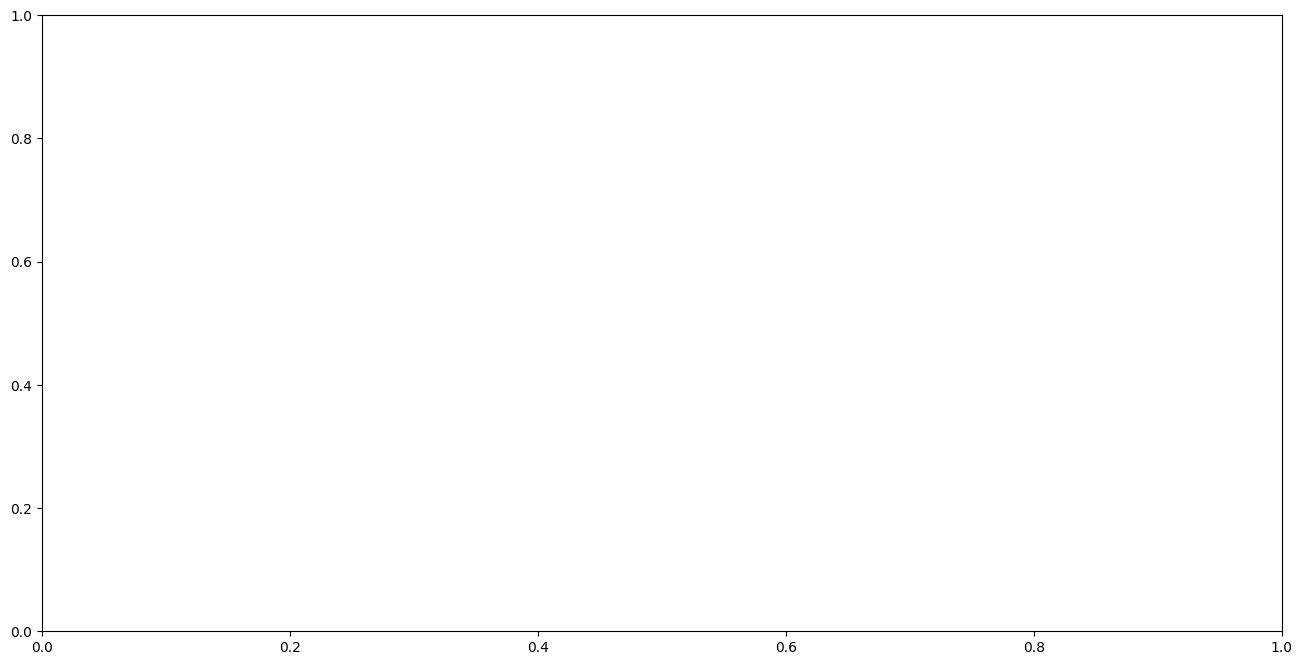

In [85]:
'''ax = plt.subplots()
y_pred = pipe.predict(X_test)
plt(y_pred)
ax.plot(y_test)
ax.plot(y_train)
plt.show()
'''

import matplotlib.pyplot as plt

# Create a figure and axis
fig, ax = plt.subplots()

# Predict using the pipeline

y_test = y_test.groupby(y_test['index'].month).mean()
y_train = y_train.groupby(y_train['Index'].month).mean()
y_pred = pipe.predict(X_test)
y_pred = pd.Series(y_pred, index = y_test.index)
y_pred = pd.DataFrame(y_pred)
# Plot the predictions and actual values
ax.plot(y_test, label='Test Data')
ax.plot(y_train, label='Train Data')
ax.plot(y_pred, label='Predictions')

# Add labels, title, and legend
ax.set_xlabel('Index')
ax.set_ylabel('Solar Radiation')
ax.set_title('Solar Radiation Predictions vs Actual Data')
ax.legend()

# Show the plot
plt.show()



In [78]:
pd.DataFrame(y_pred)

,0
Data_Hora,
2018-04-10 05:00:00,0.39170
2018-04-10 06:00:00,-0.02789
2018-04-10 07:00:00,7.88631
2018-04-10 08:00:00,103.29810
2018-04-10 09:00:00,361.67642
...,...
2019-12-30 17:00:00,575.18725
2019-12-30 18:00:00,148.40405
2019-12-30 19:00:00,-0.57647


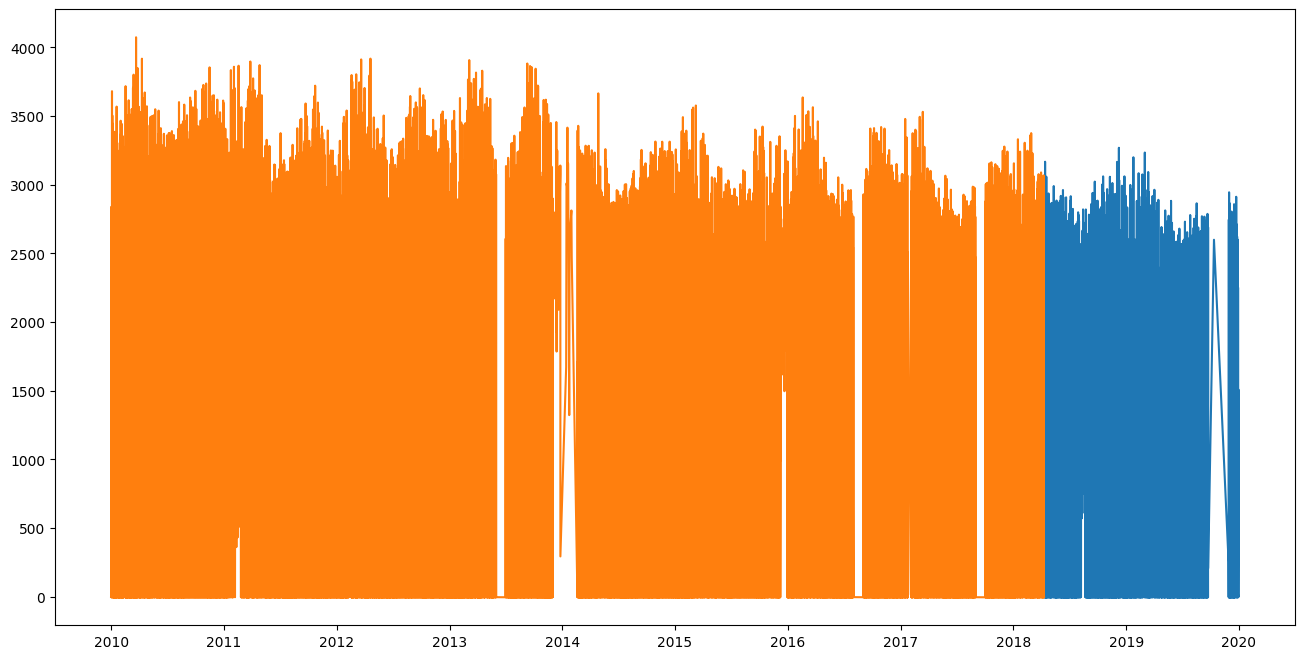

In [74]:
fig, ax = plt.subplots()
ax.plot(y_test, label='Test Data')
ax.plot(y_train, label='Train Data')
# ax.plot(y_pred, label='Predictions')
plt.show()

In [66]:
y_test

,RADIACAO GLOBAL(Kj/m²)
Data_Hora,
2018-04-10 05:00:00,0.392
2018-04-10 06:00:00,-0.028
2018-04-10 07:00:00,7.877
2018-04-10 08:00:00,103.315
2018-04-10 09:00:00,361.645
...,...
2019-12-30 17:00:00,574.713
2019-12-30 18:00:00,148.400
2019-12-30 19:00:00,-0.576


In [47]:
import joblib
filename = "Models/Piperandomforestmodel.json"
joblib.dump(pipe,filename)

['Models/Piperandomforestmodel.json']

In [42]:
loaded_model = joblib.load(filename)

In [43]:
loaded_model.score(X_test, y_test)

0.9999999936559882